# Optimizing contour segmentation 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import skimage.io
import skimage.segmentation
import skimage.morphology
import skimage.measure
import skimage.exposure
import skimage.feature
import skimage.draw

import scipy.ndimage
import scipy.signal
import scipy.interpolate
import scipy.spatial

import scipy.optimize

import glob
import itertools
%matplotlib inline

The goal of this notebook is to optimize a contour-based segmentation algorithm. This is better than simple threshold segmentation on phase contrast images as it is relatively agnostic to variance in contrast within the body of the cell. Here, I will test a variety of images and output the final segmentation masks to ensure that this approach is robust across a wide variety of images.  

In [2]:
# Define the data directory
file_names = glob.glob('SD2_5ulmin_pre_5/Pos*/*Brightfield*.tif')

# Load in all of them as an image collection. 
ims = skimage.io.ImageCollection(file_names, conserve_memory=False)

# Define an image to work with. 
im = ims[0]

The first step in the apprach is to filter the image to remove small-scale variance in contrast. This will prevent segmentation of background artifacts. We can do this by applying a relatively small gaussian blur and subtracting the two masks. 

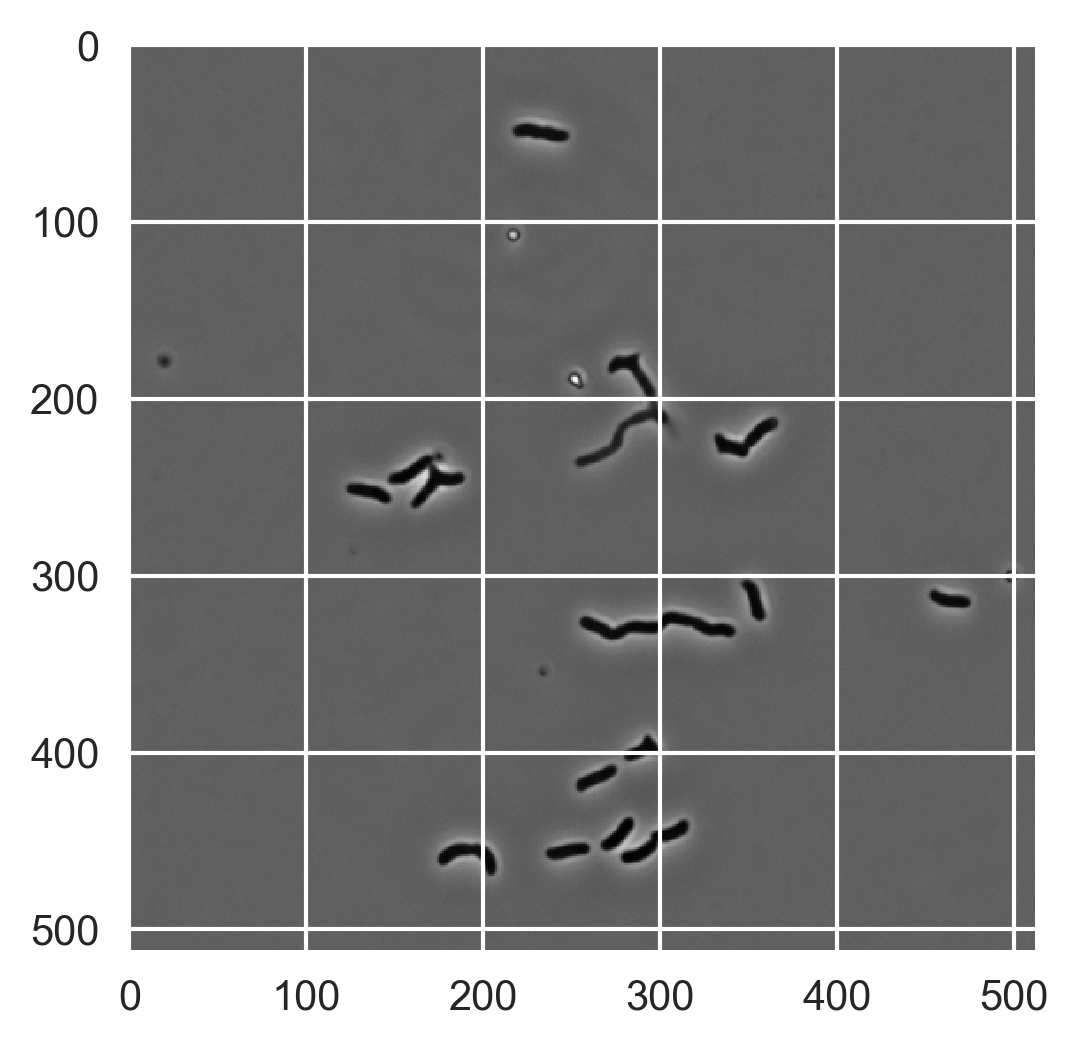

In [3]:
# Normalize the image. 
im_norm = (im - im.min()) / (im.max() - im.min())

# Blur the image. 
im_blur = skimage.filters.gaussian(im_norm, sigma=10)

# Subtract them. 
im_sub = im_norm - im_blur
plt.imshow(im_sub, cmap=plt.cm.Greys_r)

Apply a white tophat to the image.  

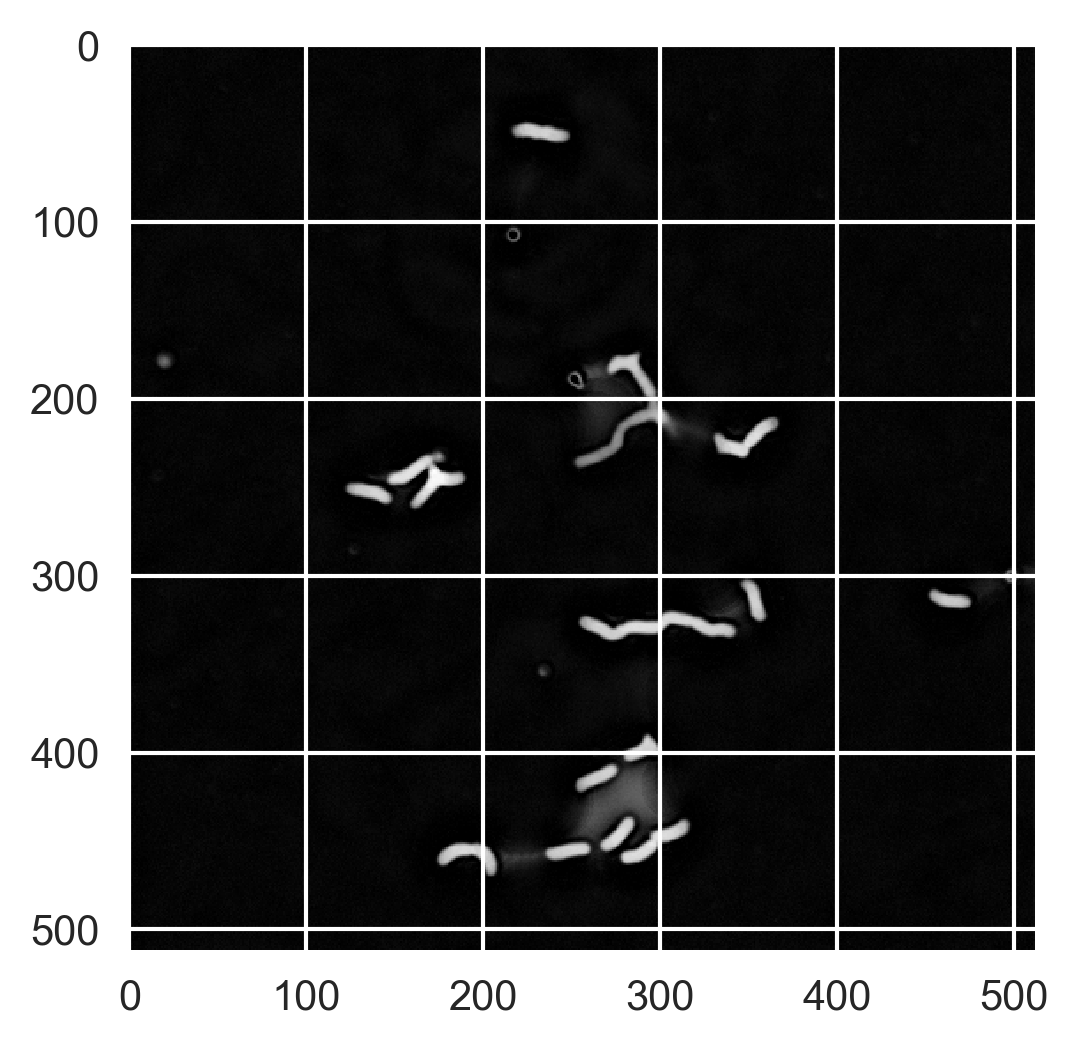

In [4]:
top_hat = skimage.morphology.black_tophat(im, skimage.morphology.disk(20))
plt.imshow(top_hat, cmap=plt.cm.Greys_r)

Now we can try to draw a contour at the lower levels of the image. We can check this value by showing a histogram of the image.

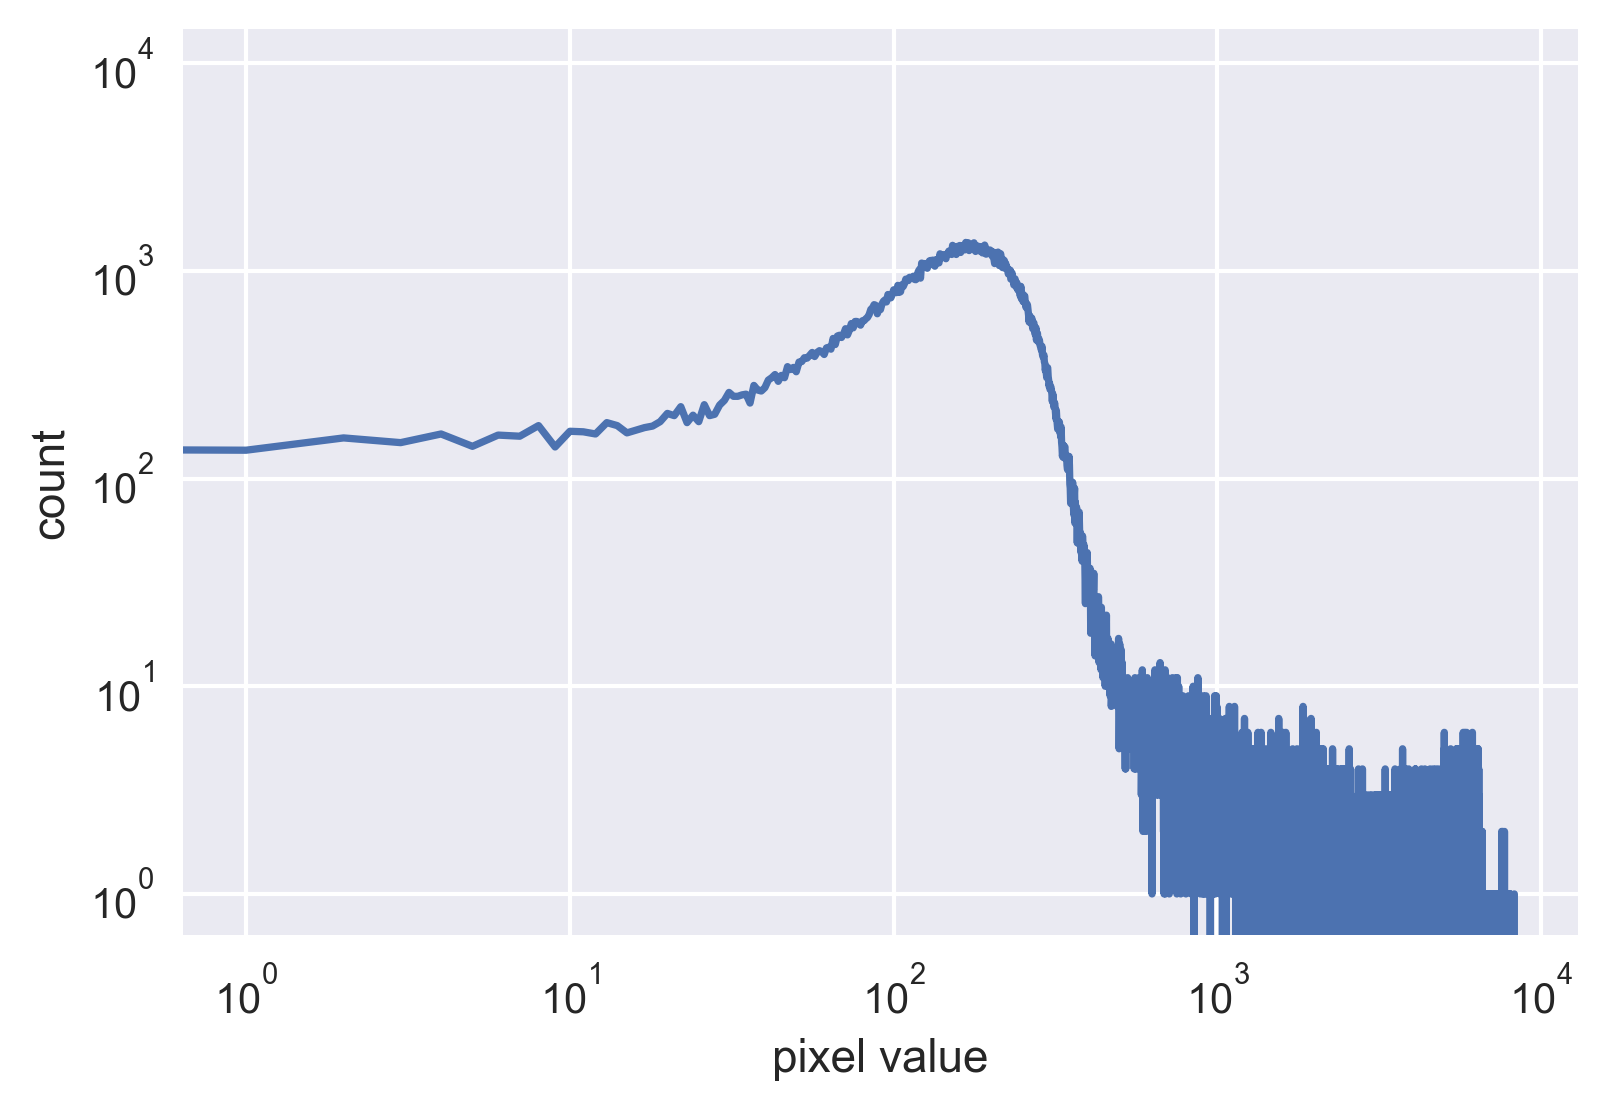

In [5]:
hist, bins = skimage.exposure.histogram(top_hat)
plt.plot(bins, hist)
plt.xlabel('pixel value')
plt.ylabel('count')
plt.yscale('log')
plt.xscale('log')

The cells seem to peter off around -0.1. We'll use this point as our level for contouring.  

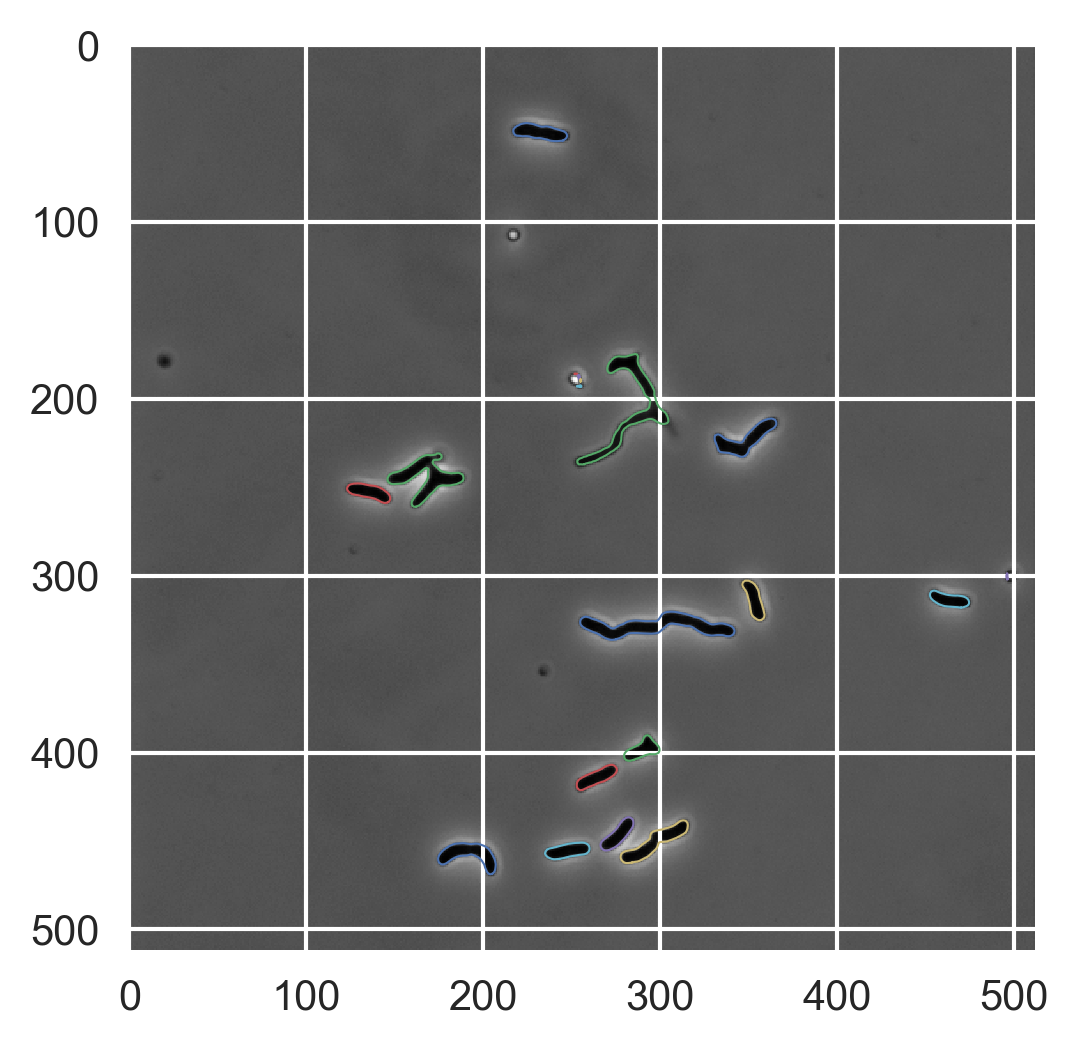

In [6]:
# Define the level and draw the contours. 
level = 3000
contours = skimage.measure.find_contours(top_hat, level)
plt.figure()
plt.imshow(im_norm, cmap=plt.cm.Greys_r)
for cont in contours:

    plt.plot(cont[:,1], cont[:,0], lw=0.5)

This contour generating procedure seems to function well for finding bacterial objects. Below, we define this as a function for easy use. 

In [7]:
def contour_seg(image, level, selem='default'):
    """
    Identifies contours around dark objects in a phase contrast image.
    
    Parameters
    ----------
    image: 2d-array
        Phase contrast image of interest. This shoul
    level: float
        Level at which to draw contours on black top-hat filtered image. 
        Default value is 4000. This is dependent on the image, but should
        be robust for images of similar illumination.
    selem: 2d-array or string
        Structuring element to use for the black top-hat filtering procedure
        Default value is a disk with a diameter of 20 pixels.
        
    Returns
    -------
    conts : 1d-array
        List of contour coordinates. Each entry of this array comes as 
        an x,y pair of arrays. Has the same length as the number of 
        contoured objects

    """
    
    # Apply the white top-hat filter.
    if selem == 'default':
        selem = skimage.morphology.disk(20)
    im_filt = skimage.morphology.black_tophat(image, selem)
    
    # Find the contours and return.
    conts = skimage.measure.find_contours(im_filt, level)
    return conts

Now that we have the contours, We have to go through each object, fit splines to the identified contours, and compute the curvature.

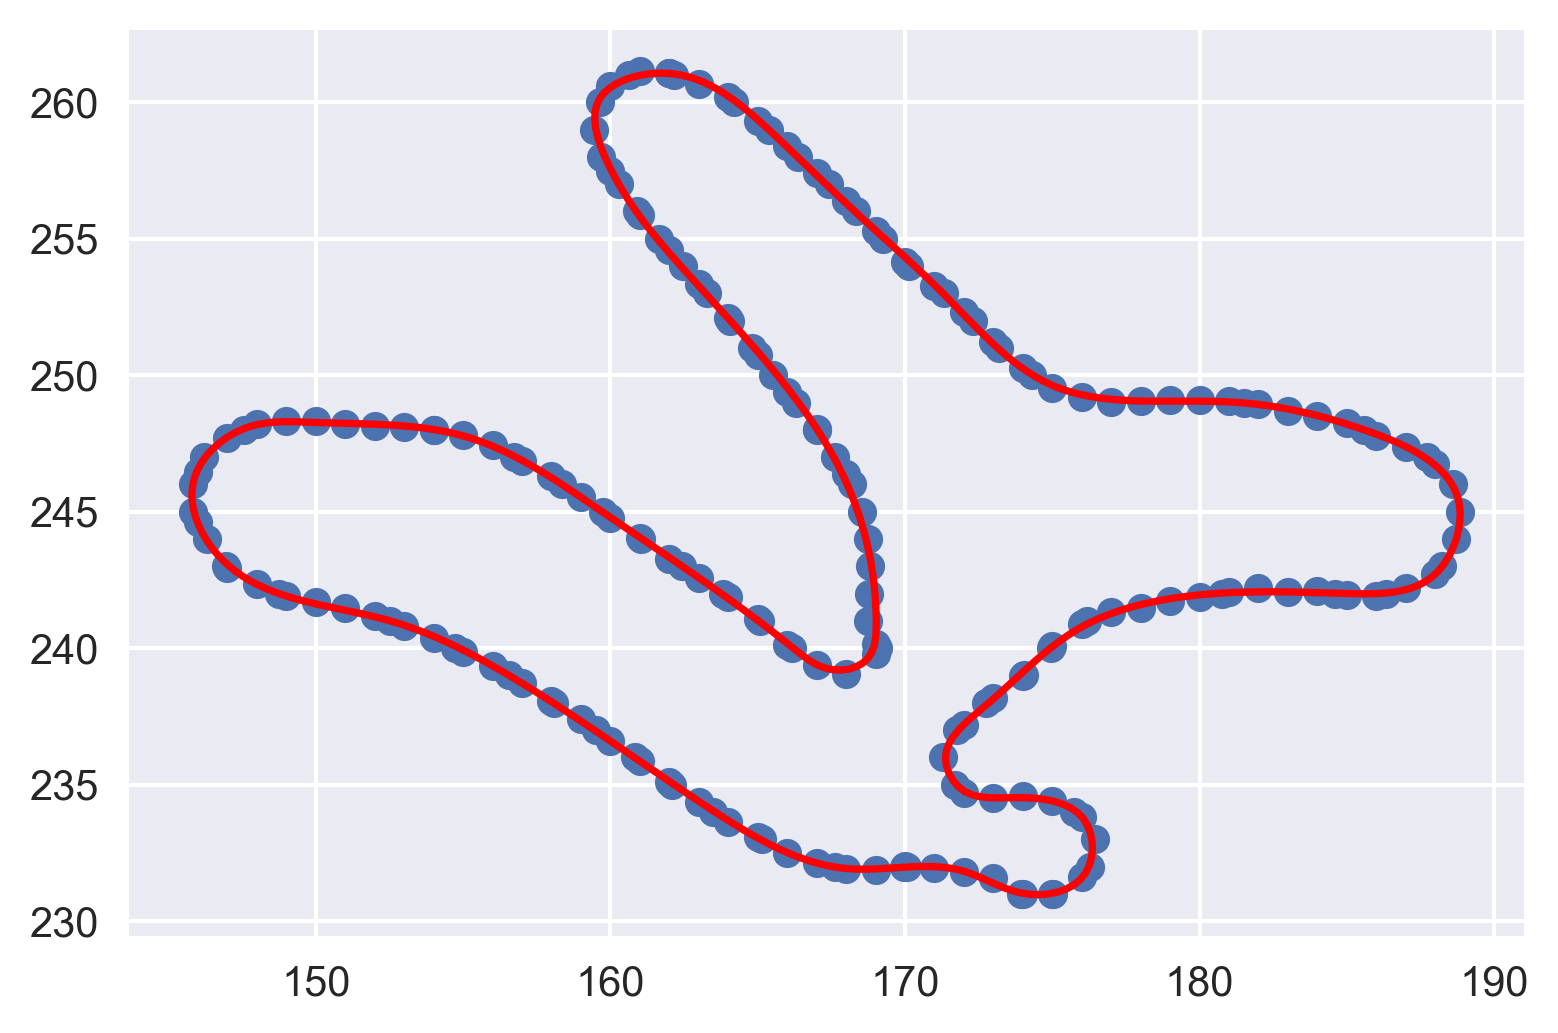

In [8]:
# Isolate one of the contours. 
ex_conts = contours[7]
cont_x, cont_y = ex_conts[:,1], ex_conts[:,0]

# Fit a spline to the contour and overlay it. 
tck, u = scipy.interpolate.splprep([cont_x, cont_y], s=1, per=1)
u_new = np.linspace(u.min(), u.max(), 500) 
x_new, y_new  = scipy.interpolate.splev(u_new, tck, der=0)

# Plot the original points and the contour
plt.plot(cont_x, cont_y, 'o')
plt.plot(x_new, y_new, 'r-')

In [19]:
# Compute the physical length of the spline.
dist = []
for i in range(len(x_new) - 1):
    x_dist = (x_new[i + 1] - x_new[i])**2
    y_dist = (y_new[i + 1] - y_new[i])**2
    dist.append(np.sqrt(x_dist + y_dist))
    

0.0485239530815


/Users/gchure/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/gchure/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/gchure/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


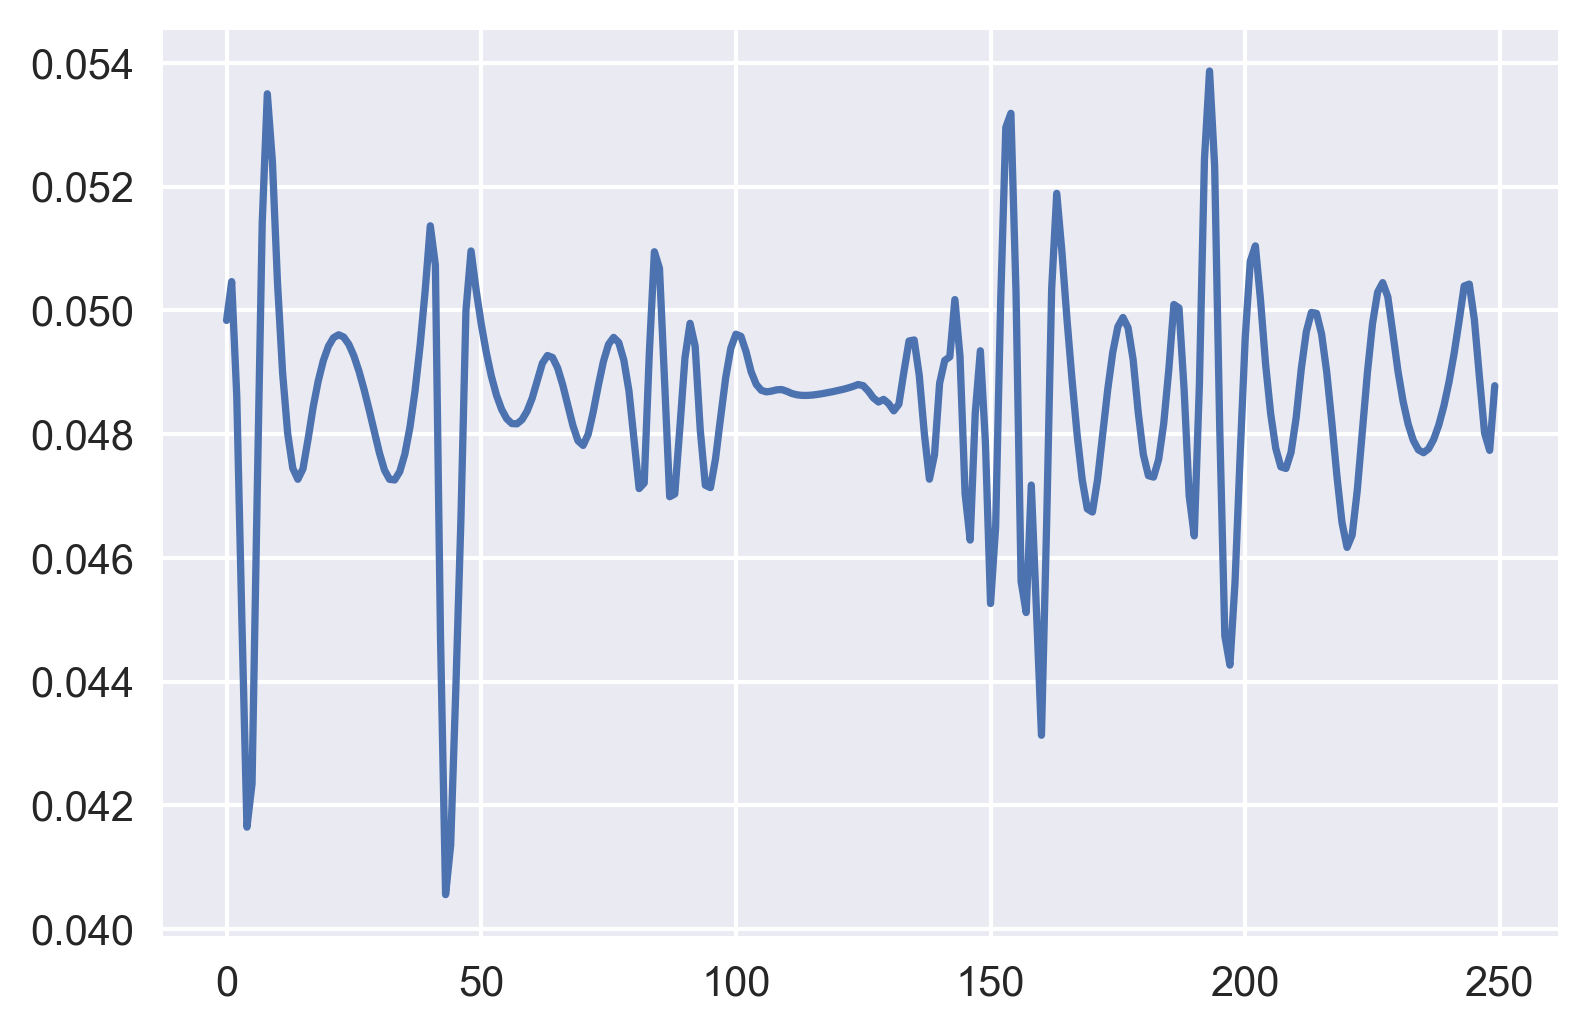

In [29]:
z =np.array(dist) * 0.160
mean_step = np.mean(z)
print(mean_step)
new_step = np.round(0.1 / mean_step)
split = z[::new_step]
plt.plot(np.arange(0, len(split)), split)
x_new = x_new[::new_step]
y_new = y_new[::new_step]

That looks pretty good. Now, let's compute the curvature along this contour. 

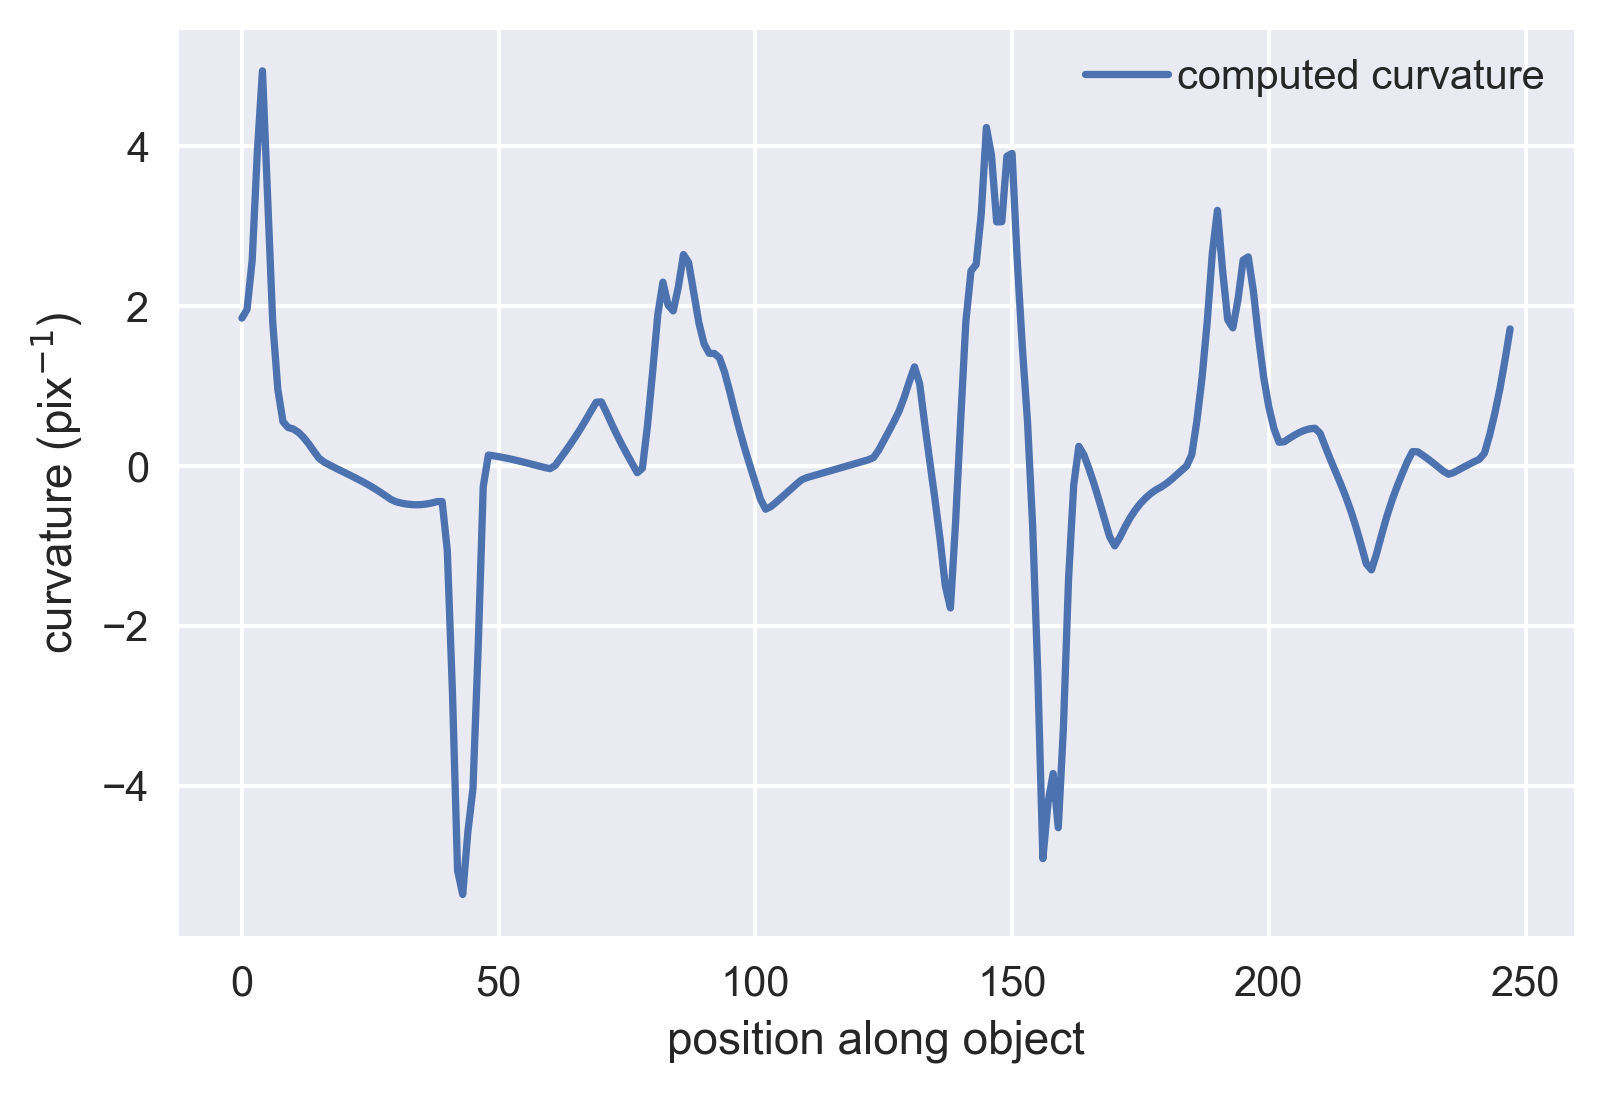

In [31]:
# Compute the differences. 
dx = np.diff(x_new)
ddx = np.diff(dx)
dy = np.diff(y_new)
ddy = np.diff(dy)

step = 1
curv = []
for i in range(len(ddx)):
    curv.append((dx[i] * ddy[i] - dy[i] * ddx[i]) / (dx[i]**2 + dy[i]**2)**(3/2))

curv = np.array(curv)
# Plot the curvature as a function of position across the object.
position = np.arange(0, len(curv), 1)

plt.plot(position, curv/0.160, label='computed curvature')
# plt.plot(position, mean_curvature, label='mean value')
plt.xlabel('position along object')
plt.ylabel('curvature (pix$^{-1}$)')
plt.legend()


As expected, we see only two points of highly negative curvature along the object. Let's now plot the curvature along the boundary of the cell with a color map. 

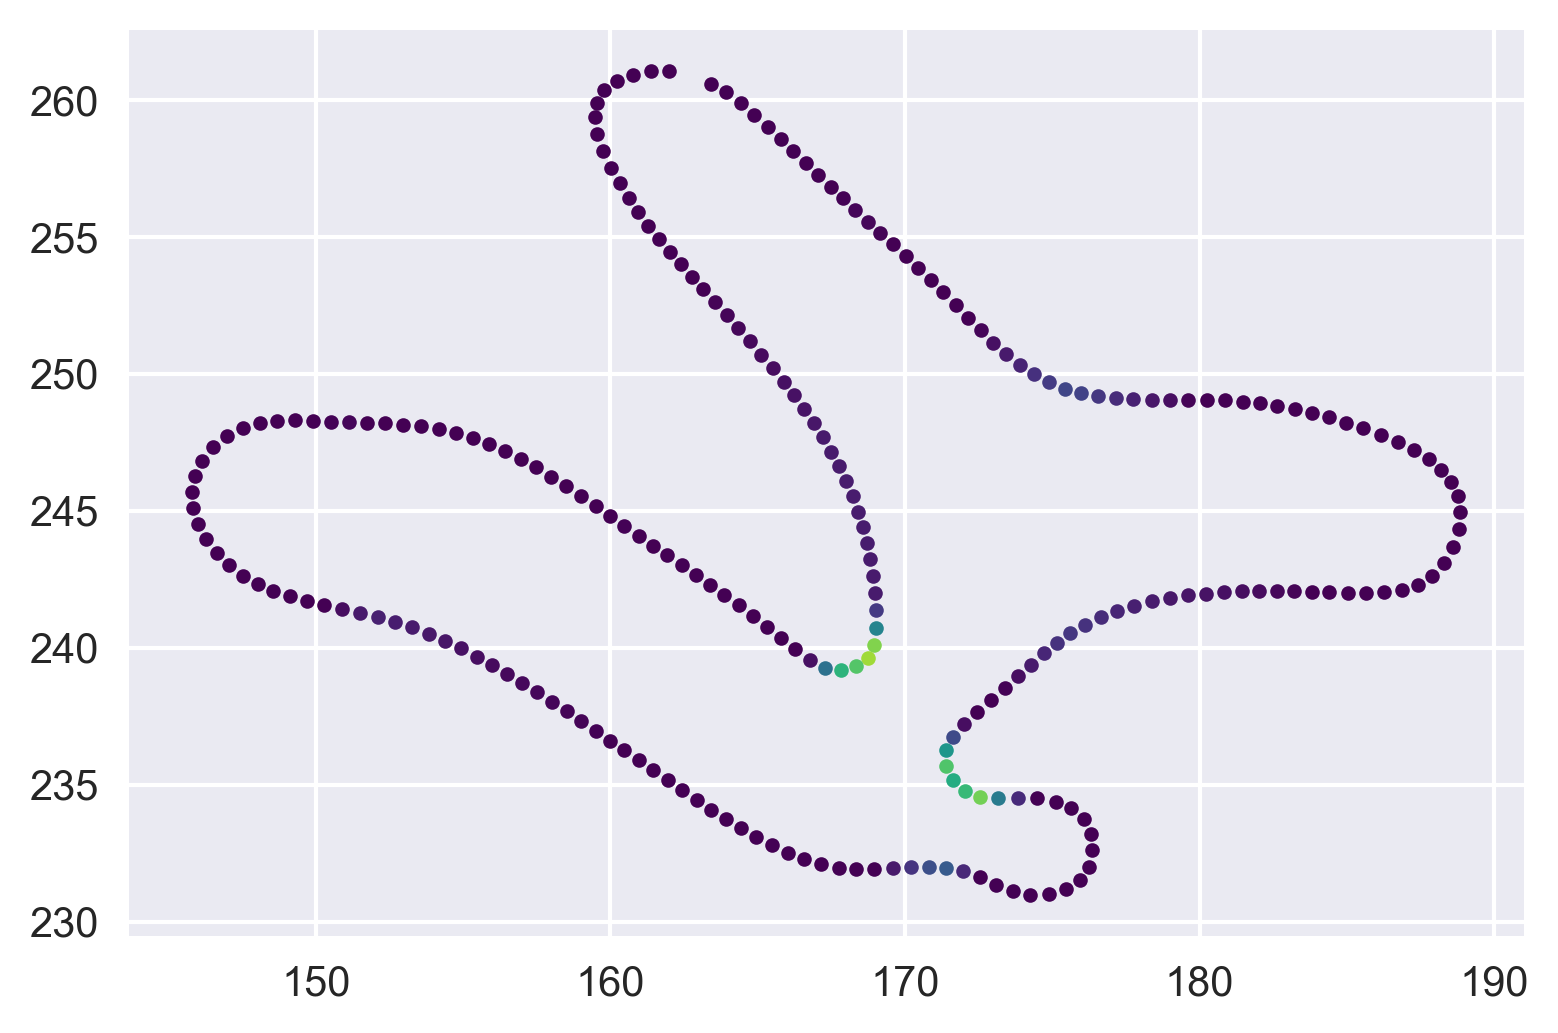

In [32]:
# Assign the colormap values to the curvature.
curve_colors = plt.cm.viridis(-curv)

# Plot the labeled curvature values. 
for i in range(len(curv)):
    plt.plot(x_new[i], y_new[i], '.', color=curve_colors[i]) 

In the above plot, regions of highly negative curvature are shown in yellow. This algorithm seems to identify the bottleneck regions very well. Given this array of curvatures, let's now identify the lowest regions and separate the objects. 

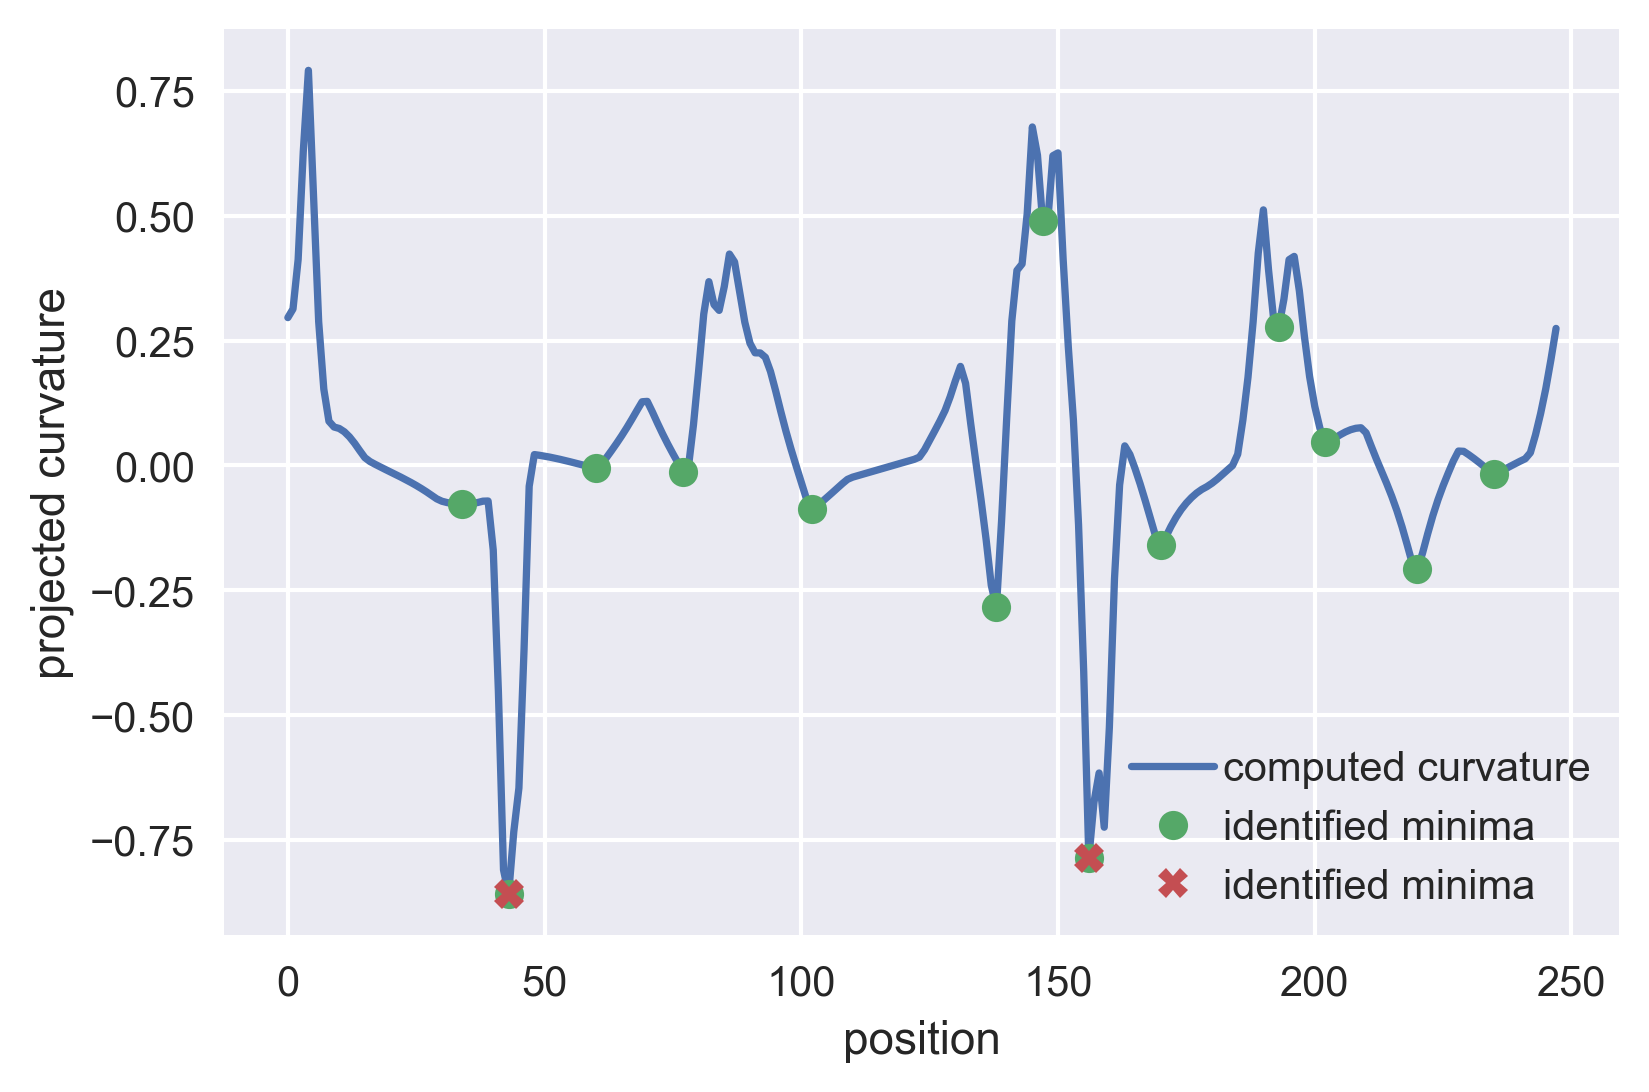

In [33]:
# Find the minima in the curvature array.
local_min = scipy.signal.argrelmin(curv, order=3)

# plot the curvature and the identified minima.
plt.plot(position, curv, '-', label='computed curvature')
plt.plot(position[local_min[0]], curv[local_min[0]], 'o', label='identified minima')

# Find only the local min below some threshold value of -0.5
locs = np.where(curv[local_min[0]] < -0.5)
loc_x = x_new[local_min[0]][locs]
loc_y = y_new[local_min[0]][locs]
plt.plot(position[local_min[0]][locs], curv[local_min[0]][locs], 'X',
        label='identified minima')

plt.xlabel('position')
plt.ylabel('projected curvature')
plt.legend()

Let's ensure that these identified positions actually correspond to the bottlenecks in our segmented object. 

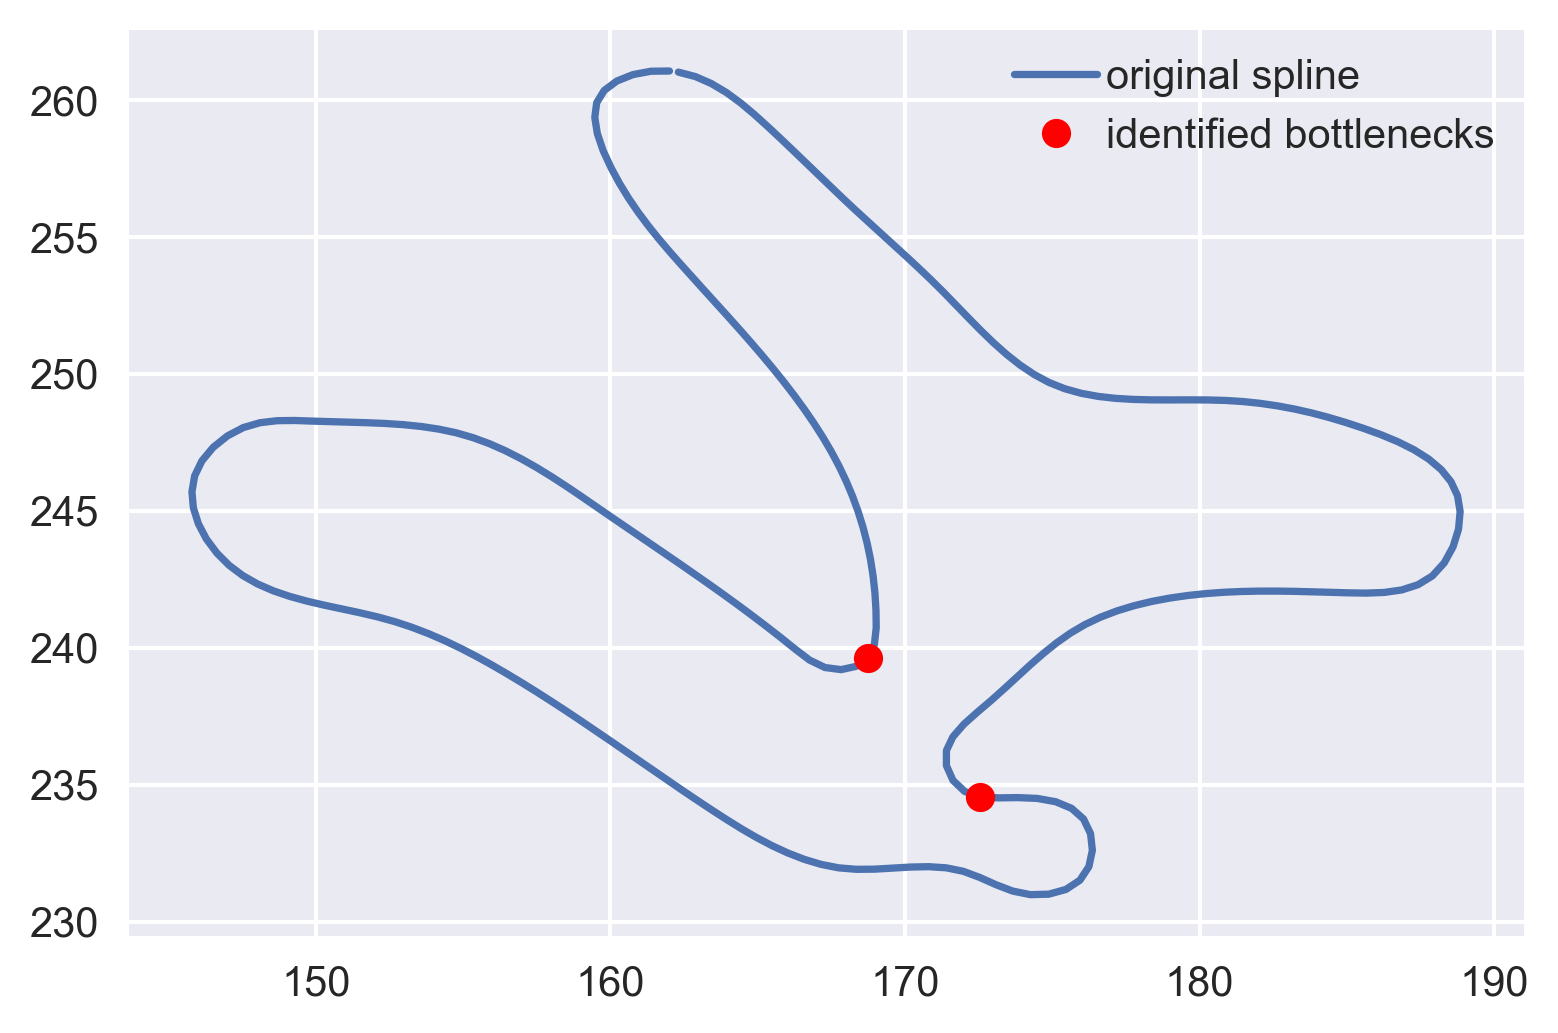

In [34]:
# Find the X and Y position of the bottle neck and plot them on the original spline.
loc_x = x_new[local_min[0]][locs]
loc_y = y_new[local_min[0]][locs]

plt.plot(x_new, y_new, '-', label='original spline')
plt.plot(loc_x, loc_y, 'ro', label='identified bottlenecks')
plt.legend()

That looks as I hoped it would. Now, let's compute the shortest pairwise distances between these regions of high curvature and figure out a way to separate the objects.

In [35]:
# Find the minimum distance. 
dists = []

for x, y in zip(loc_x, loc_y): 
    # This will be the minimum distance computed thus far
    min_dist = 1E6
    
    # This corresponds to the x and y position of the point
    # at the minimum distance
    pair = None
    
    for i, j in zip(loc_x, loc_y):
        # Ensuring we are not computing a distance of 0
        if (x != i) & (y != j):
            dist = np.sqrt((x - i)**2 + (y - j)**2)
            if dist < min_dist:
                min_dist = dist
                pair = (i, j)
    dists.append([(x, y), pair])

dists

[[(168.73849185384495, 239.62540454094136),
  (172.55312083430948, 234.55659147943956)],
 [(172.55312083430948, 234.55659147943956),
  (168.73849185384495, 239.62540454094136)]]

Now that we have ll the points that need to be connected, we have to come up with some scheme of actually connecting them. One idea is to be clever with how we can slice through the computed splines and separate them. Another is to connect the best straight line between these points and subtract them from a binary segmentation mask. This will be far more simple than other approaches, so let's give that a shot.


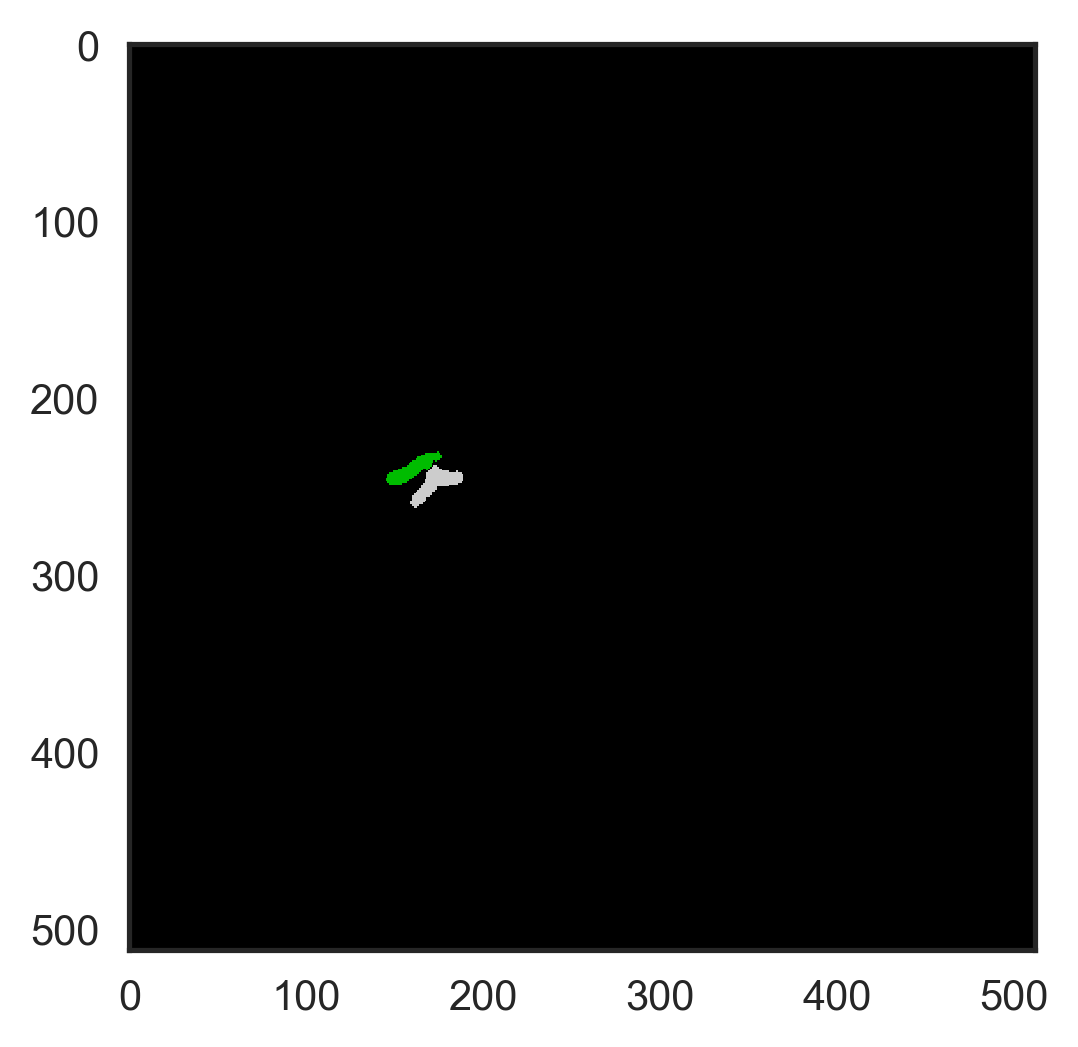

In [36]:
# Convert the contour to an image. 
im_cont = np.zeros_like(im)
x = x_new.astype(int)
y = y_new.astype(int)
im_cont[y, x] = 1.0

#  Fill it with 1.0's
im_fill = scipy.ndimage.binary_fill_holes(im_cont)

# Generate an image with the lines.
im_bottle = np.zeros_like(im)
for i, pair in enumerate(dists):
    # Round the x and y positions. 
    pair = np.round(pair).astype(int)
    
    # Draw a line between the pairs of points and include it in our image
    _line = skimage.draw.line(pair[0][1], pair[0][0], pair[1][1], pair[1][0])
    im_bottle[_line] = 1.0

# Subtract the two images to separate the cells.
im_fill = im_fill - im_bottle

# Erode and label
im_erode = skimage.morphology.erosion(im_fill)
im_lab = skimage.measure.label(im_erode, connectivity=1)
# Dilate the image. 
im_dil = skimage.morphology.dilation(im_lab)
with sns.axes_style('white'):
    plt.imshow(im_dil, cmap=plt.cm.spectral)

In [649]:
np.max(im_lab)

3

This procedure seems to work pretty well over a bunch of different images. Let's try to compress all the major points into functions and add the appropriate test cases.

In [91]:
def fit_spline(x, y, step_dist=0.2, ip_dist=0.160):
    """
    Fits a spline to a given object contour and returns the new x, y coordinates
    with 500 points. 
    
    Parameters
    ----------
    x, y : 1d-arrays
        X and Y  coordinates of the contour to upon which to fit a spline. 
    step_dist : float
        Distance between points in the final spline. This should be given
        in units of microns. Default value is 0.01 micron between points.
    ip_dist : float
        Interpixel distance of the camera. This should be given in units 
        of microns per pixel. Default value is 0.160 microns per pixel. 
        
    Returns
    -------
    spline_x, spline_y : 1d-arrays
        The X and Y coordinates of the splines.
    """
    # Instantiate the spline to the contour with high fidelity 
    tck, u = scipy.interpolate.splprep([x, y], s=0.5, per=1)
    
    # Generate a new array of positions over which to evaluate the spline
    u_new = np.linspace(u.min(), u.max(), 300) 
    
    # Fit the spline compute the mean distance
    spline_x, spline_y = scipy.interpolate.splev(u_new, tck, der=0)
    
    dist = np.zeros(len(spline_x) - 1)
    for i in range(len(spline_x) - 1):
        x_comp = (spline_x[i + 1] - spline_x[i])**2
        y_comp = (spline_y[i + 1] - spline_y[i])**2
        dist[i] = np.sqrt(x_comp + y_comp)
        
    mean_step = np.mean(dist * ip_dist)
    # Determine the slicing operation to give approximate step distance
    # and return.
    stride = np.round(step_dist / mean_step)
    if stride > 0:
        return spline_x[::stride], spline_y[::stride]
    else:
        print('interpoint distance greater than desired. Returning original spline')
        return spline_x, spline_y
     
def curvature(x, y, ip_dist=0.160):
    """
    Computes the approximate 2D curvature along a set of X and Y points.
    
    Parameters
    ----------
    x,y : 1d-arrays
        The x and y set of coordinates over which to compute the curvature.
    ip_dist : float
        Interpixel distance of the camera in units of microns per pixel. 
        This value is needed in the conversion of the curvature from 
        inverse pixels to inverse microns.
 
    Returns
    -------
    kappa : 1d-array
        The value of the curvature computed at each point using the 
        provided window size. This array will be two indices shorter than
        the provided x,y pairing.
        
    Raises
    ------
    TypeError :
        Raised if the type of the window size is not an integer.
    """     
    # Compute the derivatives. 
    dx = np.diff(x)
    ddx = np.diff(dx)
    dy = np.diff(y)
    ddy = np.diff(dy)
   
    # Instantiate the storage vector and loop through the positions.
    kappa = np.zeros(len(ddx))
    for i, _ in enumerate(ddx):
        kappa[i] = (dx[i] * ddy[i] - dy[i] * ddx[i]) /\
            (dx[i]**2 + dy[i]**2)**(3/2)  
    return kappa / ip_dist

def find_bottlenecks(x, y, kappa, thresh=-2):
    """
    Identifies bottleneck regions as points of highly negative curvature. 
   
    Parameters
    ----------
    x, y : 1d-arrays
        X and Y coordinates of spline.
    kappa : 1d-array
        Array of curvature values at each x and y position. This vector can be
        two indices shorter in length than x and y. 
    thresh : float
        Minimum curvature value to be considered as a bottleneck point. The
        default value is -0.05 inverse microns.
   
    Returns
    -------
    loc_x, loc_y : 1d-arrays
        Positions of bottle neck points. 
    """
    # Find the local minima looking over a window of three points. 
    local_min = scipy.signal.argrelmin(kappa, order=3)[0]
    
    # Find the indices at which the curvature is below the thresh value.
    locs = np.where(kappa[local_min] < thresh)
    
    # Find the x and y coordinates and return 
    loc_x = np.array(x[local_min][locs])
    loc_y = np.array(y[local_min][locs])
    return loc_x, loc_y


def compute_min_distance(x, y, return_dist=False):
    """
    Computes pairwise distances and identifies the pairs with the minimum
    distance. 
    
    Parameters
    ----------
    x, y : 1d-arrays
        Arrays of X and Y coordinates between which all pairwise distances
        will be computed. 
    return_dist : bool
        If True, the distance between the two points will also be returned. 
    
    Returns
    -------
    pairs : list 
        List of pairs of points with the minimum distance. Each entry in 
        this list is a tuple of the x and y coordinates for each point. 
    dists : list
        Minimum distances between the classified pairs.
    """ 
    # Create a storage vector for the distances.
    dists = []
    pairs = []

    for x, y in zip(loc_x, loc_y): 
        # Set an arbitrarily high minimum distance to begin with.
        min_dist = 1E10
    
        #  Set the current pair value. 
        pair = None
    
        for i, j in zip(loc_x, loc_y):
            # Ensuring we are not computing a distance of 0
            if (x != i) & (y != j):
                dist = np.sqrt((x - i)**2 + (y - j)**2)
                if dist < min_dist:
                    min_dist = dist
                    pair = (i, j)
        pairs.append([(x, y), pair])
        dists.append(min_dist)

    # Return the specified things. 
    if return_dist == True:
        return pairs, dists
    else:
        return pairs

    
def clip_bottlenecks(contour, pairs, image, index=0):
    """
    Generates a boolean mask of a contour and splits it at the 
    bottle neck points. 
    
    Params
    ------
    contour: list of lists
        Pairings of x and y coordinates of fit splines.
    pairs: list of tuples
        Pairings of bottle neck coordinates.
    index: int
        Number of previously labeled objects in image.
        
    Returns
    -------
    
    """
    # Convert the contour coordinates to integers.
    x, y = np.round(contour)

    if index == 0:
        image = np.zeros_like(image)
    x = x.astype(int)
    y = x.astype(int)
    
    # Generate the boolean mask of the contour.
    im_cont[y, x] = 1.0
    
    #  Fill it with 1.0's
    im_fill = scipy.ndimage.binary_fill_holes(im_cont)
    
    # Generate an image with the lines.
    im_bottle = np.zeros_like(image)
    for i, pair in enumerate(pairs):
        # Round the x and y positions. 
        pair = np.round(pair).astype(int)
        
        # Draw a line between the pairs of points and include it in our image
        _line = skimage.draw.line(pair[0][1], pair[0][0], pair[1][1], pair[1][0])
        im_bottle[_line] = 1.0
    
    # Subtract the two images to separate the cells.
    im_fill = im_fill - im_bottle
    
    # Erode and label
    im_erode = skimage.morphology.erosion(im_fill)
    im_lab = skimage.measure.label(im_erode)
    
    # Dilate the image. 
    im_dil = skimage.morphology.dilation(im_lab)
    return im_dil
    

Now that these are in order, let's try applying it to our stack of images and seeing how well it works. 

/Users/gchure/anaconda/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[1][167]=x[1][0]
  (i, m, i)))
/Users/gchure/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:42: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/gchure/anaconda/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[1][161]=x[1][0]
  (i, m, i)))


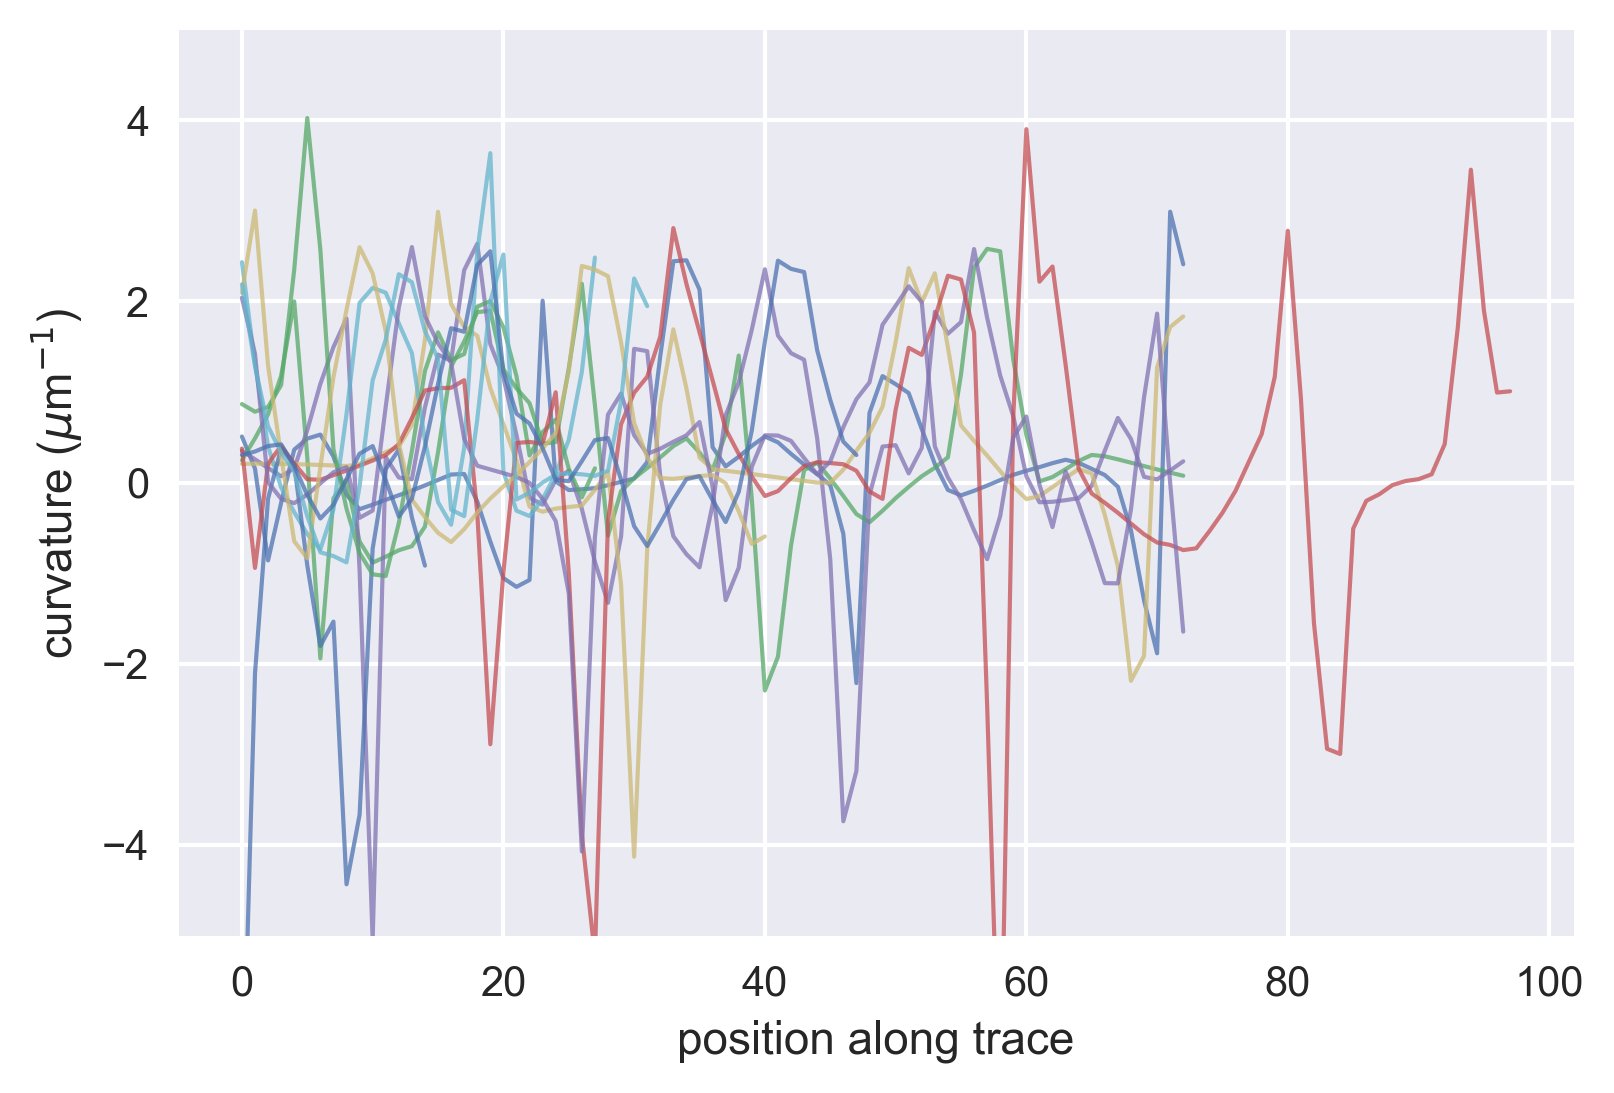

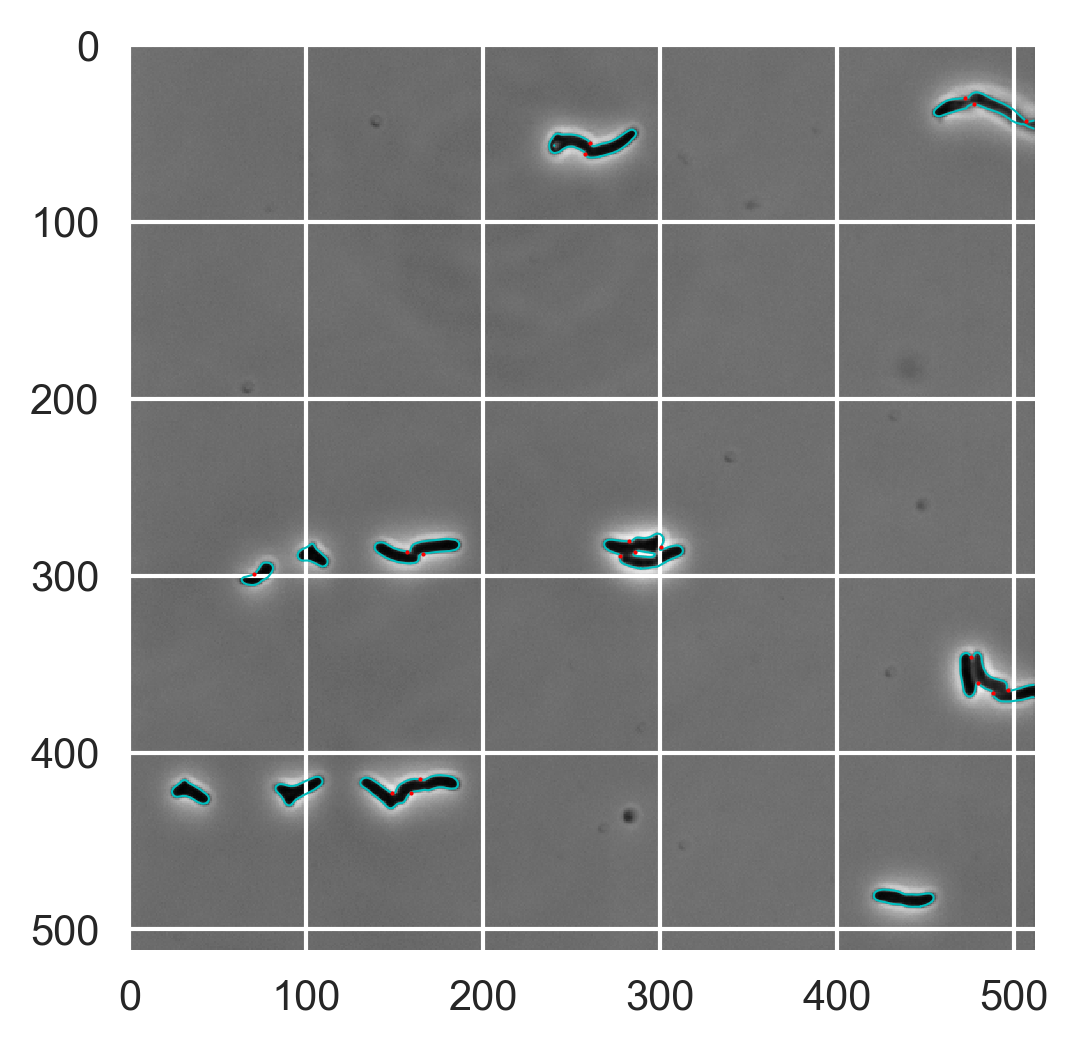

In [93]:
image = ims[2]
conts = contour_seg(image, 3000)

# Fit the splines 
splines = []
for c in conts:
    _splines = fit_spline(c[:,1], c[:,0], step_dist=0.25)
    splines.append(_splines)

fig1, ax1 = plt.subplots(1, 1)
bottles = []   
# Compute the curvature
curves = []
for s in splines:
    kappa = curvature(s[0], s[1])
    curves.append(kappa)
    ax1.plot(np.arange(0, len(kappa)), kappa, lw=1, alpha=0.75)
    
ax1.set_xlabel('position along trace')
ax1.set_ylabel('curvature ($\mu$m$^{-1}$)')
ax1.set_ylim((-5, 5))
# Find the bottle neck points. 

for i, kappa in enumerate(curves):
    _ = find_bottlenecks(splines[i][0], splines[i][1], kappa, thresh=-1)
    bottles.append(_)
    
fig2, ax2 = plt.subplots(1, 1)
ax2.imshow(image, cmap=plt.cm.Greys_r)
for c in conts:
    plt.plot(c[:,1], c[:,0], 'c-', lw=0.5)
for i, _  in enumerate(bottles):
    plt.plot(bottles[i][0], bottles[i][1], 'r.', ms=2)
#     cmap = plt.cm.viridis(-kappa)
#     for j, k in enumerate(kappa):
#         plt.plot(splines[i][0][j], splines[i][1][j], 'o', ms=1, color=cmap[j])

## Things left to do

1. Prevent lines being drawn crossing the spline in multiple points. For this, I think I can use `scipy.fsolve`
2. Choose only the minimum distances such that the total number of bottle necks is even. This may mostly be taken care of by addressing point 1. 
